In [1]:
import tensorflow as tf
tf.enable_eager_execution()

In [2]:
from astropy.io import fits
import numpy as np
import math
from pathlib import Path
from io import BytesIO
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from vacuum.model import create_model
from vacuum.io import load_data, preprocess, deprocess, fits_open

In [4]:
INPUT_DIR = "/scratch/datasets/kat7_2000/raw"

SEPARABLE_CONV = False   # use separable convolutions in the generator
NGF = 64                 # number of generator filters in first conv layer
NDF = 64                 # number of discriminator filters in first conv laye
BATCH_SIZE = 1           # number of images in batch
CROP_SIZE = 256
EPS = 1e-12
FLIP = True              # flip images horizontally during training
SCALE_SIZE = 286         # scale images to this size before cropping to 256x256
MAX_EPOCHS = 1           # number of training epochs
LR = 0.0002              # initial learning rate for adam
BETA1 = 0.5              # momentum term of adam
L1_WEIGHT = 100.0        # weight on L1 term for generator gradient
GAN_WEIGHT = 1.0         # weight on GAN term for generator gradient
INPUT_MULTIPLY = 1.0     # Use this to scale in the max input fluxes to about 5 Jy 

In [6]:
batch, count = load_data(INPUT_DIR, CROP_SIZE, FLIP, SCALE_SIZE, MAX_EPOCHS, BATCH_SIZE, INPUT_MULTIPLY)
steps_per_epoch = int(math.ceil(count / BATCH_SIZE))
iter = batch.make_one_shot_iterator()
index, psf, dirty, skymodel = iter.get_next()
print("examples count = %d" % count)

examples count = 1999


In [7]:
deprocessed_input = deprocess(dirty, INPUT_MULTIPLY)
deprocessed_target = deprocess(skymodel, INPUT_MULTIPLY)
#deprocessed_ouput = deprocess(model.outputs, INPUT_MULTIPLY)

In [8]:
dirty_roundtrip = deprocessed_input.numpy().squeeze()

In [9]:
dirty_squeeze = dirty.numpy().squeeze()

In [10]:
original = fits_open("{}/{}-wsclean-dirty.fits".format(INPUT_DIR, 0))

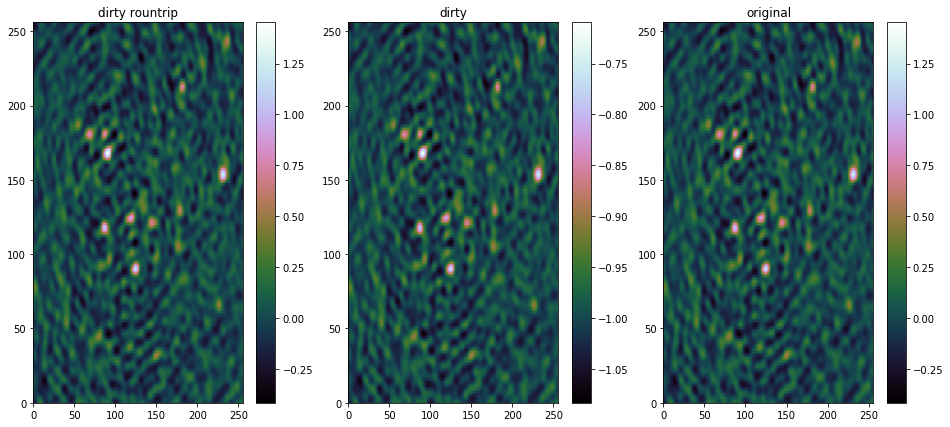

In [11]:
f, (a1, a2, a3) = plt.subplots(1, 3, figsize=(16,7))
i1 = a1.pcolor(dirty_roundtrip, cmap='cubehelix')
f.colorbar(i1, ax=a1)
a1.set_title('dirty rountrip')
i2 = a2.pcolor(dirty_squeeze, cmap='cubehelix')
f.colorbar(i2, ax=a2)
_ = a2.set_title('dirty')
i3 = a3.pcolor(original, cmap='cubehelix')
f.colorbar(i3, ax=a3)
_ = a3.set_title('original')